In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil

%matplotlib inline
plt.rcParams.update({'font.size': 20})

root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'

In [111]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.model_selection import KFold
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

In [3]:
def print_mem():
    memory_usage = psutil.Process(os.getpid()).memory_info().rss*10**-9
    print('Current memory usage: {:.2f}GB'.format(memory_usage))
print_mem()

Current memory usage: 0.62GB


In [4]:
def get_r2(true, prediction):
    u = np.sum((prediction-true)**2)
    v = np.sum((true-np.mean(true))**2)
    return 1 - u / v

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

In [6]:
directory = os.path.join(root_directory,'fly_5','func_0')
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
clustering_dir = os.path.join(directory, 'super_voxels')
brain = bbb.load_numpy_brain(brain_path)*1 # this *1 is currently important for some fucking reason
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))
print_mem()


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 7.76 ms
brain shape is x,y,z,t (77, 128, 49, 4731)
Current memory usage: 9.77GB


In [7]:
t0 = time.time()
one_slice = brain[:,:,20,:].reshape(-1, brain.shape[-1])
print(time.time()-t0)

0.678363561630249


In [8]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.71 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.82 sec


In [9]:
resolution = 100 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw,
                                                   fps,
                                                   resolution,
                                                   expt_len,
                                                   behavior,
                                                   timestamps=timestamps,
                                                   smoothing=51)
    fictrac[short] = fictrac[short]/np.std(fictrac[short])
xnew = np.arange(0,expt_len,resolution)

In [10]:
for behavior in ['Y', 'Z']:
    fictrac_std = np.std(fictrac[behavior])
    fictrac[behavior] = np.divide(fictrac[behavior],fictrac_std)

In [11]:
connectivity = grid_to_graph(77,128)

In [12]:
Y_glm = fictrac['Y']

In [13]:
n_clusters = [9856,9000,8000,7000,6000,5000,4000,3000,2000,1500,1000,750,500,100,10,1]

cluster_signals = {}

for cluster in n_clusters:
    print('working on cluster {}'.format(cluster))
    model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage='ward',
                                    connectivity=connectivity)
    model = model.fit(one_slice)

    signals = []
    for cluster_num in range(cluster):
        cluster_indicies = np.where(model.labels_==cluster_num)[0]
        mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
    X_glm=np.asarray(signals).T
    
    cluster_signals[cluster] = X_glm

working on cluster 9856
working on cluster 9000
working on cluster 8000
working on cluster 7000
working on cluster 6000
working on cluster 5000
working on cluster 4000
working on cluster 3000
working on cluster 2000
working on cluster 1500
working on cluster 1000
working on cluster 750
working on cluster 500
working on cluster 100
working on cluster 10
working on cluster 1


In [14]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [192]:
#timestr = time.strftime("%Y%m%d")
load_path = os.path.join(clustering_dir, 'models')
load_files = os.listdir(load_path)
scores_loaded = {}
for file in load_files:
    with open(os.path.join(load_path, file)) as json_file:
        scores_loaded[file[9:-5]] = json.load(json_file)

In [117]:
scores_loaded['lasso_ward']['2000']

{'0.0001': {'test': -0.04423803000201339, 'train': 0.761973212899071},
 '0.001': {'test': 0.18883826200652543, 'train': 0.7484046173677551},
 '0.01': {'test': 0.4409904173292021, 'train': 0.5681471971457721},
 '0.1': {'test': 0.22195350638697123, 'train': 0.23277133146253673},
 '1.0': {'test': -0.0008108151419883747, 'train': -6.217248937900876e-16},
 '10.0': {'test': -0.0008108151419883747, 'train': -6.217248937900876e-16},
 '100.0': {'test': -0.0008108151419883747, 'train': -6.217248937900876e-16},
 '1000.0': {'test': -0.0008108151419883747, 'train': -6.217248937900876e-16},
 '10000.0': {'test': -0.0008108151419883747, 'train': -6.217248937900876e-16},
 '100000.0': {'test': -0.0008108151419883747, 'train': -6.217248937900876e-16},
 '1000000.0': {'test': -0.0008108151419883747,
  'train': -6.217248937900876e-16},
 '10000000.0': {'test': -0.0008108151419883747,
  'train': -6.217248937900876e-16}}

In [193]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]

In [194]:
best_r2s = {}
best_alpha = {}

for method in scores_loaded:
    best_r2s[method] = []
    best_alpha[method] = []
    for cluster in n_clusters:
        r2s = [scores_loaded[method][str(cluster)][str(x)]['test'] for x in alphas]
        best_r2s[method].append(np.max(r2s))
        best_alpha[method].append(alphas[np.argmax(r2s)])

In [195]:
[x for x in scores_loaded]

['lasso_ward',
 'lasso_complete',
 'ridge_wardcc',
 'lasso_single',
 'lasso_wardcc',
 'elasticnet_wardcc',
 'lasso_avg']

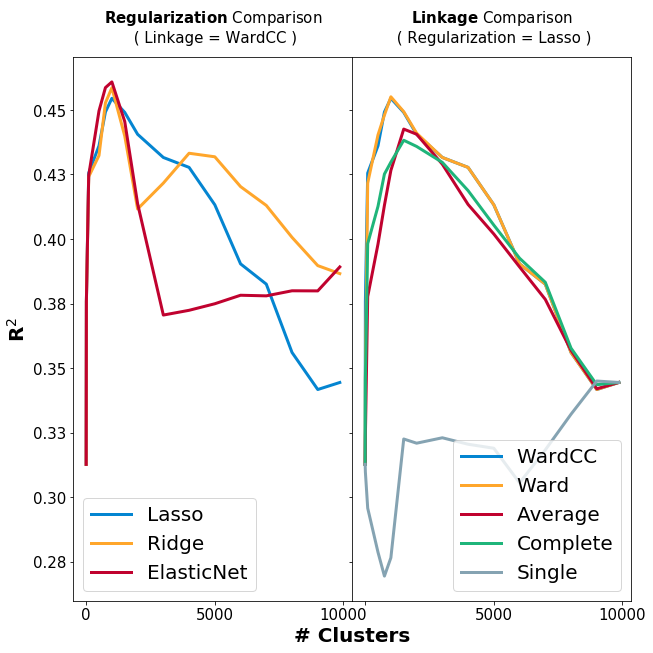

In [211]:
fig, axs = plt.subplots(1,2, figsize=(10,10), sharey=True)

colors = ['xkcd:cerulean', 'xkcd:mango', 'xkcd:lipstick red', 'xkcd:dark seafoam', 'xkcd:bluegrey']

#colors = cm.ocean(np.linspace(0,1,10))

#ax1.set_ylabel('R$^2$')
for i,method in enumerate(['lasso_wardcc', 'ridge_wardcc', 'elasticnet_wardcc']):
    axs[0].plot(n_clusters, best_r2s[method], label=method, color=colors[i], linewidth=3)

for i,method in enumerate(['lasso_wardcc', 'lasso_ward', 'lasso_avg', 'lasso_complete', 'lasso_single']):
    axs[1].plot(n_clusters, best_r2s[method], label=method, color=colors[i], linewidth=3)
    
axs[0].set_title('{} Comparison\n ( Linkage = WardCC )'.format(r"$\bf{"+'Regularization'+"}$"),fontsize=15, y=1.02)
axs[1].set_title('{} Comparison\n ( Regularization = Lasso )'.format(r"$\bf{"+'Linkage'+"}$"), fontsize=15, y=1.02)

axs[0].legend(['Lasso', 'Ridge', 'ElasticNet'])
axs[1].legend(['WardCC', 'Ward', 'Average', 'Complete', 'Single'])

axs[0].set_ylabel('R$^2$', fontweight='bold')

def my_formater(x, pos):
    return '{:.2f}'.format(x)

formatter = FuncFormatter(my_formater)
axs[0].yaxis.set_major_formatter(formatter)

#plt.suptitle(x=.5,y=.98,t='fly_5, slice_20\n manual alpha sweep and 5-fold CV, shuffled sampling.\n method comparison',fontsize=15)
plt.subplots_adjust(wspace=0, hspace=0)

for i in [0,1]:
    for j, label in enumerate(axs[i].get_xticklabels()):
        label.set_ha('center')
        #label.set_rotation(45)
        label.set_fontsize(15)
        if i == 1 and j == 1:
            label.set_visible(False)

for label in axs[0].get_yticklabels():
    label.set_fontsize(15)
            
axs[0].set_xlabel('# Clusters', x=1, fontweight='bold')
        
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [212]:
best_alpha

{'elasticnet_wardcc': [0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_avg': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_complete': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_single': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.001,
  0.0001],
 'lasso_ward': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_wardcc': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'ridge_wardcc': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  

In [253]:
connectivity

<9856x9856 sparse matrix of type '<class 'numpy.int64'>'
	with 48870 stored elements in COOrdinate format>

In [260]:
best_alpha

{'elasticnet_wardcc': [0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.1,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_avg': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_complete': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_single': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.001,
  0.0001],
 'lasso_ward': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'lasso_wardcc': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.001,
  0.0001,
  0.0001],
 'ridge_wardcc': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  

In [270]:
[x for x in scores_loaded]

['lasso_ward',
 'lasso_complete',
 'ridge_wardcc',
 'lasso_single',
 'lasso_wardcc',
 'elasticnet_wardcc',
 'lasso_avg']

In [271]:
[x for x in best_r2s]

['lasso_ward',
 'lasso_complete',
 'ridge_wardcc',
 'lasso_single',
 'lasso_wardcc',
 'elasticnet_wardcc',
 'lasso_avg']

In [274]:
_regularization = ['lasso', 'lasso', 'ridge', 'lasso', 'lasso', 'elasticnet', 'lasso']
_linkage = ['ward', 'complete', 'ward', 'single', 'ward', 'ward', 'average']
_connectivity = [None, None, connectivity, None, connectivity, connectivity, None]

In [273]:
[best_alpha['elasticnet_wardcc'][i] for i in [0,8]]

[0.1, 0.01]

In [279]:
maps = {}
scores = {}

for k, method in enumerate(scores_loaded):
    clusters_now = [n_clusters[i] for i in [0,8]]
    alphas_now = [best_alpha[method][i] for i in [0,8]]
    print('METHOD: {}'.format(method))
    for cluster, alpha in zip(clusters_now, alphas_now):
        print(cluster)
        t0=time.time()
        dict_name = method + '_' + str(cluster)

        ### CLUSTER ###
        print('linkage: {}'.format(_linkage[k]))
        model = AgglomerativeClustering(n_clusters=cluster,
                                    memory=clustering_dir,
                                    linkage=_linkage[k],
                                    connectivity=_connectivity[k])
        model = model.fit(one_slice)

        ### CREATE FEATURES BASED ON CLUSTER AVERAGES ###
        signals = []
        for cluster_num in range(cluster):
            cluster_indicies = np.where(model.labels_==cluster_num)[0]
            mean_signal = np.mean(one_slice[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
        X_glm = np.asarray(signals).T
        
        ### Fit Linear Model ###
        scores[dict_name] = {}

        train_scores, test_scores, coefs = [], [], []

        if _regularization[k] == 'lasso':
            modelglm = Lasso(alpha=alpha)
            print('regularization: lasso')
        elif _regularization[k] == 'ridge':
            modelglm = Ridge(alpha=alpha)
            print('regularization: ridge')
        elif _regularization[k] == 'elasticnet':
            modelglm = ElasticNet(alpha=alpha)
            print('regularization: elasticnet')
        else:
            print('INVALID REGULARIZAION')
        
        for train_index, test_index in kf.split(X_glm):

            X_train, X_test = X_glm[train_index], X_glm[test_index]
            Y_train, Y_test = Y_glm[train_index], Y_glm[test_index]
                
            modelglm.fit(X_train, Y_train)
            train_scores.append(modelglm.score(X_train, Y_train))
            test_scores.append(modelglm.score(X_test, Y_test))
            coefs.append(modelglm.coef_)

        scores[dict_name]['train'] = np.mean(train_scores)
        scores[dict_name]['test'] = np.mean(test_scores)
        scores[dict_name]['coef'] = np.mean(coefs,axis=0)

        ### Color brain by coefs ###
        colored_by_betas = np.zeros(77*128)
        for cluster_num in range(cluster):
            cluster_indicies = np.where(model.labels_==cluster_num)[0]
            colored_by_betas[cluster_indicies] = scores[dict_name]['coef'][cluster_num]
        colored_by_betas = colored_by_betas.reshape(77,128)

        maps[dict_name] = colored_by_betas

        #print('duration {:.0f}s'.format(time.time()-t0))

METHOD: lasso_ward
9856
linkage: ward
using lasso
duration 15s
2000
linkage: ward
using lasso
duration 3s
METHOD: lasso_complete
9856
linkage: complete
using lasso
duration 14s
2000
linkage: complete
using lasso
duration 2s
METHOD: ridge_wardcc
9856
linkage: ward
using ridge
duration 8s
2000
linkage: ward
using ridge
duration 2s
METHOD: lasso_single
9856
linkage: single
using lasso
duration 14s
2000
linkage: single
using lasso
duration 2s
METHOD: lasso_wardcc
9856
linkage: ward
using lasso
duration 12s
2000
linkage: ward
using lasso
duration 2s
METHOD: elasticnet_wardcc
9856
linkage: ward
using elasticnet
duration 8s
2000
linkage: ward
using elasticnet
duration 4s
METHOD: lasso_avg
9856
linkage: average
using lasso
duration 14s
2000
linkage: average
using lasso
duration 2s


In [282]:
keys=list(maps.keys())

In [283]:
keys_new = [keys[x] for x in [0,2,4,6,8,10,12,1,3,5,7,9,11,13]]

In [293]:
keys_new =['ridge_wardcc_9856',
 'elasticnet_wardcc_9856',
 'lasso_wardcc_9856',
 
 'lasso_ward_9856',
 'lasso_complete_9856',
 'lasso_single_9856',
 'lasso_avg_9856',
 
 'ridge_wardcc_2000',
 'elasticnet_wardcc_2000',
 'lasso_wardcc_2000',

 'lasso_ward_2000',
 'lasso_complete_2000',
 'lasso_single_2000',
 'lasso_avg_2000']

In [359]:
scores['lasso_ward_2000']['test']

0.4409904168350506

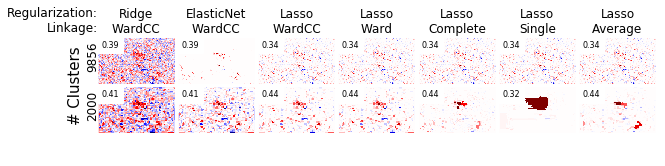

In [365]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 7), axes_pad=0.05)
#n_clusters = [9856, 1000]
x_labels = ['Ridge\nWardCC', 'ElasticNet\nWardCC', 'Lasso\nWardCC',
            'Lasso\nWard', 'Lasso\nComplete', 'Lasso\nSingle', 'Lasso\nAverage']
for i,method in enumerate(keys_new):
    grid[i].imshow(maps[method][:-1,:], cmap='seismic', vmin=-np.max(maps[method]), vmax=np.max(maps[method]))
    grid[i].axis('off')
    grid[i].text(x=5,y=15,s='{:0.2f}'.format(scores[method]['test']),fontsize=8,backgroundcolor='white')
    if i < 7:
        grid[i].set_title(x_labels[i],fontsize=12)
grid[0].text(-20,20,'9856',rotation=90,fontsize=12)
grid[7].text(-20,20,'2000',rotation=90,fontsize=12)
grid[7].text(-50,-50,'# Clusters',rotation=90,fontsize=15)

grid[0].text(0,-37,'Regularization:',fontsize=12, ha='right')
grid[0].text(0,-12,'Linkage:',fontsize=12, ha='right')


#     grid[i].set_title('{} clusters, R$^2$: {:.2f}'.format(cluster, scores[cluster]['test']),
#                       fontsize=12,
#                       x=.5,y=1.1,
#                       horizontalalignment='center',
#                       verticalalignment='top')
#plt.suptitle(x=.5,y=.8,t='fly_5, slice_20, sklearn.Lasso, manual alpha/CV, complete linkage',fontsize=15)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr)
plt.savefig(fname,dpi=300,bbox_inches='tight')